In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
cd gdrive/My Drive/Lung_Segmentation/

/content/gdrive/My Drive/Lung_Segmentation


**Importing Required Libraries**

In [ ]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import numpy as np
import cv2
import os
from sklearn import metrics
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.autograd import Variable as V

**Data Loading and Preprocessing**

In [ ]:
def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.randint(hue_shift_limit[0], hue_shift_limit[1]+1)
        hue_shift = np.uint8(hue_shift)
        h += hue_shift
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        #image = cv2.merge((s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image

def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0, 0.0),
                           scale_limit=(-0.0, 0.0),
                           rotate_limit=(-0.0, 0.0), 
                           aspect_limit=(-0.0, 0.0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags = cv2.INTER_LINEAR, borderMode = borderMode,borderValue = (0, 0,0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags = cv2.INTER_LINEAR, borderMode = borderMode, borderValue = (0, 0,0,))

    return image, mask

def randomFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask

def randomRotate90(image, mask, u=0.5):
    if np.random.random() < u:
        image=np.rot90(image)
        mask=np.rot90(mask)

    return image, mask
      
def loader(img_path, mask_path, phase):

    img = cv2.imread(img_path)
    img = cv2.resize(img, (448, 448))

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (448, 448))
    
    if(phase == 'train'):
        img = randomHueSaturationValue(img,
                                      hue_shift_limit=(-30, 30),
                                      sat_shift_limit=(-5, 5),
                                      val_shift_limit=(-15, 15))

        img, mask = randomShiftScaleRotate(img, mask,
                                          shift_limit=(-0.1, 0.1),
                                          scale_limit=(-0.1, 0.1),
                                          aspect_limit=(-0.1, 0.1),
                                          rotate_limit=(-0, 0))
        img, mask = randomFlip(img, mask)
        img, mask = randomRotate90(img, mask)

    img = np.array(img, np.float32).transpose(2,0,1)/255.0 
    mask = np.array(mask, np.float32)
    mask = mask[np.newaxis,:,:]
    mask = mask/255.0
    mask[mask >= 0.5] = 1
    mask[mask < 0.5] = 0
    
    return img, mask


def read_dataset(root_path, mode='train'):

    images = []
    masks = []

    if(mode == 'train'):
        image_root = os.path.join(root_path, 'training/images')
        gt_root = os.path.join(root_path, 'training/masks')
    else : 
        image_root = os.path.join(root_path, 'testing/images')
        gt_root = os.path.join(root_path, 'testing/masks')


    for image_name in os.listdir(image_root):
        image_path = os.path.join(image_root, image_name.split('.')[0] + '.tif')
        label_path = os.path.join(gt_root, image_name.split('.')[0] + '.tif')

        images.append(image_path)
        masks.append(label_path)

    # print(images, masks)

    return images, masks

class Lung_Dataset(Dataset):

    def __init__(self, root_path, phase='train'):
        self.root = root_path
        self.phase = phase
        self.images, self.labels = read_dataset(self.root, self.phase)

    def __getitem__(self, index):

        img, mask = loader(self.images[index], self.labels[index], self.phase)
        img = torch.tensor(img, dtype = torch.float32)
        mask = torch.tensor(mask, dtype = torch.float32)
        return img, mask

    def __len__(self):
        assert len(self.images) == len(self.labels), 'The number of images must be equal to labels'
        return len(self.images)

**Context Encoder Architecture**

In [ ]:
# Dilated Atrous Convolution

class DAC(nn.Module):
    
    def __init__(self,channels):
        
        super(DAC, self).__init__()
        self.conv11 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 1, padding = 1)
        
        self.conv21 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 3, padding = 3)
        self.conv22 = nn.Conv2d(channels, channels, kernel_size = 1, dilation = 1, padding = 0)
        
        self.conv31 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 1, padding = 1)
        self.conv32 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 3, padding = 3)
        self.conv33 = nn.Conv2d(channels, channels, kernel_size = 1, dilation = 1, padding = 0)
        
        self.conv41 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 1, padding = 1)
        self.conv42 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 3, padding = 3)
        self.conv43 = nn.Conv2d(channels, channels, kernel_size = 3, dilation = 5, padding = 5)
        self.conv44 = nn.Conv2d(channels, channels, kernel_size = 1, dilation = 1, padding = 0)
        
    def forward(self, x):
        
        c1 = F.relu(self.conv11(x))
        
        c2 = self.conv21(x)
        c2 = F.relu(self.conv22(c2))
        
        c3 = self.conv31(x)
        c3 = self.conv32(c3)
        c3 = F.relu(self.conv33(c3))
        
        c4 = self.conv41(x)
        c4 = self.conv42(c4)
        c4 = self.conv43(c4)
        c4 = F.relu(self.conv44(c4))
        
        c = x + c1 + c2 + c3 + c4 
        
        return c

# Residual Multi Kernel Pooling

class RMP(nn.Module):
    
    def __init__(self,channels):
        super(RMP, self).__init__()

        self.max1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1 = nn.Conv2d(channels, 1, kernel_size = 1)
        
        self.max2 = nn.MaxPool2d(kernel_size = 3, stride = 3)
        self.conv2 = nn.Conv2d(channels, 1, kernel_size = 1)
        
        self.max3 = nn.MaxPool2d(kernel_size = 5, stride = 5)
        self.conv3 = nn.Conv2d(channels, 1, kernel_size = 1)
       
        self.max4 = nn.MaxPool2d(kernel_size = 6)
        self.conv4 = nn.Conv2d(channels, 1, kernel_size = 1)
        
    def forward(self, x):
        
        m1 = self.max1(x)
        m1 = F.interpolate(self.conv1(m1), size = x.size()[2:], mode = 'bilinear' )
        
        m2 = self.max2(x)
        m2 = F.interpolate(self.conv2(m2), size = x.size()[2:], mode = 'bilinear' )
        
        m3 = self.max3(x)
        m3 = F.interpolate(self.conv3(m3), size = x.size()[2:], mode = 'bilinear' )
        
        m4 = self.max4(x)
        m4 = F.interpolate(self.conv4(m4), size = x.size()[2:], mode = 'bilinear' )
        
        m = torch.cat([m1,m2,m3,m4,x], axis = 1)
        
        return m
        
# Decoder Architecture

class Decoder(nn.Module):
    def __init__(self, in_channels, n_filters):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.bn1 = nn.BatchNorm2d(in_channels // 4)

        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels // 4)

        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.bn3 = nn.BatchNorm2d(n_filters)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        return x

# Main Architecture   

class CE_Net_(nn.Module):
    def __init__(self, num_classes = 1, num_channels=3):
        super(CE_Net_, self).__init__()

        filters = [64, 128, 256, 512]
        resnet = models.resnet34(pretrained=True)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.maxpool1 = resnet.maxpool

        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.dac = DAC(512)
        self.rmp = RMP(512)

        self.decoder4 = Decoder(516, filters[2])
        self.decoder3 = Decoder(filters[2], filters[1])
        self.decoder2 = Decoder(filters[1], filters[0])
        self.decoder1 = Decoder(filters[0], filters[0])

        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 4, 2, 1)
        self.finalconv2 = nn.Conv2d(32, num_classes, 3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.maxpool1(x)

        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Center
        e4 = self.dac(e4)
        e4 = self.rmp(e4)

        # Decoder
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        out = F.relu(self.finaldeconv1(d1))
        out = self.finalconv2(out)

        return torch.sigmoid(out)

**Constants**

In [ ]:
root_path = '/content/gdrive/My Drive/Lung_Segmentation/Lung/'
input_size = (3,448,448)
batch_size = 8
learning_rate = 0.0002
epochs = 100

INITAL_EPOCH_LOSS = 10000
NUM_EARLY_STOP = 20
NUM_UPDATE_LR = 10

device = torch.device('cuda') 

**Dice Coefficient binary cross entropy Loss Function**

In [ ]:
class dice_bce_loss(nn.Module):
    def __init__(self, batch=True):
        super(dice_bce_loss, self).__init__()
        self.batch = batch
        self.bce_loss = nn.BCELoss()

    def soft_dice_coeff(self, y_true, y_pred):
        smooth = 0.0  # may change
        if self.batch:
            i = torch.sum(y_true)
            j = torch.sum(y_pred)
            intersection = torch.sum(y_true * y_pred)
        else:
            i = y_true.sum(1).sum(1).sum(1)
            j = y_pred.sum(1).sum(1).sum(1)
            intersection = (y_true * y_pred).sum(1).sum(1).sum(1)
        score = (2. * intersection + smooth) / (i + j + smooth)
        # score = (intersection + smooth) / (i + j - intersection + smooth)#iou
        return score.mean()

    def soft_dice_loss(self, y_true, y_pred):
        loss = 1 - self.soft_dice_coeff(y_true, y_pred)
        return loss

    def __call__(self, y_true, y_pred):
        a = self.bce_loss(y_pred, y_true)
        b = self.soft_dice_loss(y_true, y_pred)
        return a



**Accuracy and Sensitivity**

In [ ]:
def acc_sen(pred, mask) :

    pred = torch.round(pred)
    TP = (mask * pred).sum(1).sum(1).sum(1)
    TN = ((1 - mask) * (1 - pred)).sum(1).sum(1).sum(1)
    FP = pred.sum(1).sum(1).sum(1) - TP
    FN = mask.sum(1).sum(1).sum(1) - TP
    acc = (TP + TN)/ (TP + TN + FP + FN)
    acc = torch.sum(acc)

    sen = TP / (TP + FN)
    sen = torch.sum(sen)
    return acc, sen

**Frame work**

In [ ]:
class MyFrame():
    def __init__(self, net, learning_rate, device, evalmode=False):
        self.net = net().to(device)
        self.optimizer = torch.optim.Adam(params=self.net.parameters(), lr=learning_rate)
        self.loss = dice_bce_loss().to(device)
        self.lr = learning_rate
        
    def set_input(self, img_batch, mask_batch=None):
        self.img = img_batch
        self.mask = mask_batch
        
    def optimize(self):

        self.optimizer.zero_grad()
        pred = self.net.forward(self.img)
        loss = self.loss(self.mask, pred)
        loss.backward()
        self.optimizer.step()
        return loss, pred
        
    def save(self, path):
        torch.save(self.net.state_dict(), path)
        
    def load(self, path):
        self.net.load_state_dict(torch.load(path))

    def update_lr(self, new_lr, factor=False):

        if factor:
            new_lr = self.lr / new_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr

        print ('update learning rate: %f -> %f' % (self.lr, new_lr))
        print ('update learning rate: %f -> %f' % (self.lr, new_lr))
        self.lr = new_lr

**Main**

In [ ]:
train_dataset = Lung_Dataset(root_path = root_path, phase = 'train')
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)

In [ ]:
solver = MyFrame(CE_Net_, learning_rate, device)
no_optim = 0
train_epoch_best_loss = INITAL_EPOCH_LOSS
Loss = []
Accuracy = []
Sensitivity = []
for epoch in range(1, epochs + 1):
    print('Epoch {}/{}'.format(epoch, epochs))
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_sen = 0

    # index = 0
    length = len(train_loader)
    iterator = tqdm(enumerate(train_loader), total=length, leave=False, desc=f'Epoch {epoch}/{epochs}')
    for index, (img, mask) in iterator :

        img = img.to(device)
        mask = mask.to(device)

        solver.set_input(img, mask)
        train_loss, pred = solver.optimize()
        train_acc, train_sen = acc_sen(pred,mask)
        train_loss = train_loss.detach().cpu().numpy()
        train_acc = train_acc.detach().cpu().numpy()
        train_sen = train_sen.detach().cpu().numpy()

        train_epoch_loss += train_loss
        train_epoch_acc += train_acc
        train_epoch_sen += train_sen
        # index = index + 1
        # print(index, end = ' ')

    train_epoch_loss = train_epoch_loss/len(train_loader)
    train_epoch_acc = train_epoch_acc/len(train_dataset)
    train_epoch_sen = train_epoch_sen/len(train_dataset)

    print('train_loss:', train_epoch_loss)
    print('train_accuracy:', train_epoch_acc)
    print('train_sensitivity:', train_epoch_sen)

    Loss.append(train_epoch_loss)
    Accuracy.append(train_epoch_acc)
    Sensitivity.append(train_epoch_sen)
    
    if train_epoch_loss >= train_epoch_best_loss:
        no_optim += 1
    else:
        no_optim = 0
        train_epoch_best_loss = train_epoch_loss
        solver.save('final_cenet_weights.th')

    if no_optim > NUM_UPDATE_LR:
        if solver.lr < 1e-9:
            break
        solver.load('final_cenet_weights.th')
        solver.update_lr(2.0, factor=True)

    if no_optim > NUM_EARLY_STOP:
        print('early stop at %d epoch' % epoch)
        print('early stop at %d epoch' % epoch)
        break
    

    print('---------------------------------------------')

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


train_loss: 0.6075651700849887
train_accuracy: 0.7409243828782411
train_sensitivity: 0.1050184117311376
---------------------------------------------
Epoch 2/100


train_loss: 0.351722385596346
train_accuracy: 0.7636545729414325
train_sensitivity: 0.0
---------------------------------------------
Epoch 3/100


train_loss: 0.2281264684818409
train_accuracy: 0.7656269073486328
train_sensitivity: 0.0
---------------------------------------------
Epoch 4/100


train_loss: 0.20414631620601373
train_accuracy: 0.7813837104868666
train_sensitivity: 0.07077669330111544
---------------------------------------------
Epoch 5/100


train_loss: 0.18647652864456177
train_accuracy: 0.9454000553238058
train_sensitivity: 0.7828004638725352
---------------------------------------------
Epoch 6/100


train_loss: 0.1705396843177301
train_accuracy: 0.9830082688376168
train_sensitivity: 0.949577935388155
---------------------------------------------
Epoch 7/100


train_loss: 0.1307760140410176
train_accuracy: 0.9852962694435476
train_sensitivity: 0.9679731966179108
---------------------------------------------
Epoch 8/100


train_loss: 0.0738091019016725
train_accuracy: 0.9867852514035234
train_sensitivity: 0.9766695388009615
---------------------------------------------
Epoch 9/100


train_loss: 0.051725522304574646
train_accuracy: 0.9878747084430445
train_sensitivity: 0.9794339220100474
---------------------------------------------
Epoch 10/100


train_loss: 0.044002615536252655
train_accuracy: 0.9877313587153069
train_sensitivity: 0.9804271983209057
---------------------------------------------
Epoch 11/100


train_loss: 0.043668897063643845
train_accuracy: 0.9868809686642941
train_sensitivity: 0.9765862794680016
---------------------------------------------
Epoch 12/100


train_loss: 0.04121524868188081
train_accuracy: 0.9879217192391369
train_sensitivity: 0.9791798279664227
---------------------------------------------
Epoch 13/100


train_loss: 0.04147051736988403
train_accuracy: 0.9879258859937436
train_sensitivity: 0.9792415516398777
---------------------------------------------
Epoch 14/100


train_loss: 0.04287142030618809
train_accuracy: 0.9870573337947097
train_sensitivity: 0.9784241547094328
---------------------------------------------
Epoch 15/100


train_loss: 0.041157088001017215
train_accuracy: 0.9877974808773148
train_sensitivity: 0.9771884646371146
---------------------------------------------
Epoch 16/100


train_loss: 0.03905187271259449
train_accuracy: 0.9887612824128053
train_sensitivity: 0.9802013089723676
---------------------------------------------
Epoch 17/100


train_loss: 0.03833125980088004
train_accuracy: 0.9890319008693517
train_sensitivity: 0.9798019979601709
---------------------------------------------
Epoch 18/100


train_loss: 0.03580572890738646
train_accuracy: 0.9892921514600237
train_sensitivity: 0.9802036018015068
---------------------------------------------
Epoch 19/100


train_loss: 0.03915644312898318
train_accuracy: 0.9883669625932925
train_sensitivity: 0.9800542693271815
---------------------------------------------
Epoch 20/100


train_loss: 0.03428300180368953
train_accuracy: 0.9893587660566668
train_sensitivity: 0.9801866718541796
---------------------------------------------
Epoch 21/100


train_loss: 0.037879986964442114
train_accuracy: 0.9887972724771945
train_sensitivity: 0.9806297850386004
---------------------------------------------
Epoch 22/100


train_loss: 0.039421735193442414
train_accuracy: 0.9892484718394057
train_sensitivity: 0.9805186441011517
---------------------------------------------
Epoch 23/100


train_loss: 0.03616363789748262
train_accuracy: 0.9894660722429507
train_sensitivity: 0.9803093281861778
---------------------------------------------
Epoch 24/100


train_loss: 0.038132043831326345
train_accuracy: 0.9884726154469998
train_sensitivity: 0.9812097482592146
---------------------------------------------
Epoch 25/100


train_loss: 0.04229770518011517
train_accuracy: 0.9876751610051806
train_sensitivity: 0.9759390487849156
---------------------------------------------
Epoch 26/100


train_loss: 0.03667489377160867
train_accuracy: 0.9894667585319448
train_sensitivity: 0.980567221329591
---------------------------------------------
Epoch 27/100


train_loss: 0.03468181496417081
train_accuracy: 0.9897247809115971
train_sensitivity: 0.9806459707634472
---------------------------------------------
Epoch 28/100


train_loss: 0.03492361707267938
train_accuracy: 0.9893539976850848
train_sensitivity: 0.9818118376152538
---------------------------------------------
Epoch 29/100


train_loss: 0.03012701406798981
train_accuracy: 0.9898971508596545
train_sensitivity: 0.9816965477488865
---------------------------------------------
Epoch 30/100


train_loss: 0.028498119881583586
train_accuracy: 0.9906389557312583
train_sensitivity: 0.9831744733257829
---------------------------------------------
Epoch 31/100


train_loss: 0.03506724060409599
train_accuracy: 0.9895672619899857
train_sensitivity: 0.9804375327636148
---------------------------------------------
Epoch 32/100


train_loss: 0.038139143889700924
train_accuracy: 0.989290718720338
train_sensitivity: 0.9804595185217456
---------------------------------------------
Epoch 33/100


train_loss: 0.03130794447605257
train_accuracy: 0.9900388695369257
train_sensitivity: 0.9816945312179137
---------------------------------------------
Epoch 34/100


train_loss: 0.03019358093539874
train_accuracy: 0.9902364450080372
train_sensitivity: 0.9832306777205423
---------------------------------------------
Epoch 35/100


train_loss: 0.028321564680448285
train_accuracy: 0.9905946477551326
train_sensitivity: 0.9824648460495138
---------------------------------------------
Epoch 36/100


train_loss: 0.029152903153940483
train_accuracy: 0.9908004052171083
train_sensitivity: 0.9835847493644073
---------------------------------------------
Epoch 37/100


train_loss: 0.03337205408347978
train_accuracy: 0.9896696817095034
train_sensitivity: 0.9811716347097237
---------------------------------------------
Epoch 38/100


train_loss: 0.027920033230825706
train_accuracy: 0.9904465942739327
train_sensitivity: 0.982436861947318
---------------------------------------------
Epoch 39/100


train_loss: 0.03327837217323206
train_accuracy: 0.9886435571117936
train_sensitivity: 0.9830707857541949
---------------------------------------------
Epoch 40/100


train_loss: 0.03395362805437158
train_accuracy: 0.9903003055358601
train_sensitivity: 0.9814336946077435
---------------------------------------------
Epoch 41/100


train_loss: 0.03209692343241639
train_accuracy: 0.9899444624642345
train_sensitivity: 0.9824036304081711
---------------------------------------------
Epoch 42/100


train_loss: 0.03312903725438648
train_accuracy: 0.9899844900469914
train_sensitivity: 0.9823819031225187
---------------------------------------------
Epoch 43/100


train_loss: 0.030612893195615873
train_accuracy: 0.9904456316867721
train_sensitivity: 0.9816686839700859
---------------------------------------------
Epoch 44/100


train_loss: 0.027709546602434583
train_accuracy: 0.9907875283856258
train_sensitivity: 0.9827829075750903
---------------------------------------------
Epoch 45/100


train_loss: 0.037009387380546994
train_accuracy: 0.9886534882483081
train_sensitivity: 0.9818794682761219
---------------------------------------------
Epoch 46/100


train_loss: 0.030060616735782888
train_accuracy: 0.9904082668161838
train_sensitivity: 0.9813987228357903
---------------------------------------------
Epoch 47/100


train_loss: 0.02614469853816209
train_accuracy: 0.991040203058831
train_sensitivity: 0.9829659907617302
---------------------------------------------
Epoch 48/100


train_loss: 0.024503945959387003
train_accuracy: 0.991586112530432
train_sensitivity: 0.9849081418224584
---------------------------------------------
Epoch 49/100


train_loss: 0.024584584524510084
train_accuracy: 0.9918767937989993
train_sensitivity: 0.9863430785241528
---------------------------------------------
Epoch 50/100


train_loss: 0.03193852126046463
train_accuracy: 0.9897338229919148
train_sensitivity: 0.9822312693729579
---------------------------------------------
Epoch 51/100


train_loss: 0.02904561979489194
train_accuracy: 0.9909549227384763
train_sensitivity: 0.9825631458068562
---------------------------------------------
Epoch 52/100


train_loss: 0.023128281416440452
train_accuracy: 0.9920400013433439
train_sensitivity: 0.9861036505654593
---------------------------------------------
Epoch 53/100


train_loss: 0.0268324531821741
train_accuracy: 0.991193693374919
train_sensitivity: 0.9846416566973535
---------------------------------------------
Epoch 54/100


train_loss: 0.026693542418932473
train_accuracy: 0.9911579439573199
train_sensitivity: 0.98274973396943
---------------------------------------------
Epoch 55/100


train_loss: 0.023596932594146993
train_accuracy: 0.9919299321753956
train_sensitivity: 0.9851062832591689
---------------------------------------------
Epoch 56/100


train_loss: 0.02248444808302102
train_accuracy: 0.9920596318824269
train_sensitivity: 0.9859764018905497
---------------------------------------------
Epoch 57/100


train_loss: 0.022078944404643995
train_accuracy: 0.9923698746155356
train_sensitivity: 0.9869779203539697
---------------------------------------------
Epoch 58/100


train_loss: 0.02365936749373321
train_accuracy: 0.991712149058547
train_sensitivity: 0.9847529558377845
---------------------------------------------
Epoch 59/100


train_loss: 0.02626624117019
train_accuracy: 0.9916088625649425
train_sensitivity: 0.9850188326612811
---------------------------------------------
Epoch 60/100


train_loss: 0.02275348471960536
train_accuracy: 0.9919926117513781
train_sensitivity: 0.9858615398406982
---------------------------------------------
Epoch 61/100


train_loss: 0.021837895356670575
train_accuracy: 0.9923849907990928
train_sensitivity: 0.9865387511030536
---------------------------------------------
Epoch 62/100


train_loss: 0.02459610150092178
train_accuracy: 0.9912802950244084
train_sensitivity: 0.9833355974928241
---------------------------------------------
Epoch 63/100


train_loss: 0.04031833223308678
train_accuracy: 0.9865932308624838
train_sensitivity: 0.9808233341323995
---------------------------------------------
Epoch 64/100


train_loss: 0.032860345103674464
train_accuracy: 0.9895161847087824
train_sensitivity: 0.9808278373468702
---------------------------------------------
Epoch 65/100


train_loss: 0.027527940907964
train_accuracy: 0.9904756947098491
train_sensitivity: 0.9828430536751435
---------------------------------------------
Epoch 66/100


train_loss: 0.0245493630775147
train_accuracy: 0.9914319314689279
train_sensitivity: 0.98339854668234
---------------------------------------------
Epoch 67/100


train_loss: 0.021659376996534842
train_accuracy: 0.9922329465919566
train_sensitivity: 0.9858932272296086
---------------------------------------------
Epoch 68/100


train_loss: 0.025948972234295473
train_accuracy: 0.9911055765419363
train_sensitivity: 0.9848168275066626
---------------------------------------------
Epoch 69/100


train_loss: 0.026751021647618875
train_accuracy: 0.9907302254828337
train_sensitivity: 0.9846907998913916
---------------------------------------------
Epoch 70/100


train_loss: 0.027783242502698192
train_accuracy: 0.9908594394398627
train_sensitivity: 0.9830045900612234
---------------------------------------------
Epoch 71/100


train_loss: 0.030089738399342255
train_accuracy: 0.9888819177574086
train_sensitivity: 0.9817601186092769
---------------------------------------------
Epoch 72/100


train_loss: 0.02920551939556996
train_accuracy: 0.9904354398495683
train_sensitivity: 0.9818498999158912
---------------------------------------------
Epoch 73/100


train_loss: 0.02858691093408399
train_accuracy: 0.9909386434287668
train_sensitivity: 0.984210502321475
---------------------------------------------
Epoch 74/100


train_loss: 0.025887938181835192
train_accuracy: 0.9915836503572553
train_sensitivity: 0.9842977679778482
---------------------------------------------
Epoch 75/100


train_loss: 0.022977336344343645
train_accuracy: 0.9919673683487367
train_sensitivity: 0.9848407139287931
---------------------------------------------
Epoch 76/100


train_loss: 0.019675504623187914
train_accuracy: 0.9926472802028478
train_sensitivity: 0.986349785439322
---------------------------------------------
Epoch 77/100


train_loss: 0.021740979032108077
train_accuracy: 0.99232318468183
train_sensitivity: 0.9857076930108472
---------------------------------------------
Epoch 78/100


train_loss: 0.01953812716183839
train_accuracy: 0.9927614604201273
train_sensitivity: 0.9872761819964258
---------------------------------------------
Epoch 79/100


train_loss: 0.021199157358043723
train_accuracy: 0.9923260991818437
train_sensitivity: 0.9851182175573902
---------------------------------------------
Epoch 80/100


train_loss: 0.019988625620802242
train_accuracy: 0.9924469127833286
train_sensitivity: 0.9870871405735194
---------------------------------------------
Epoch 81/100


train_loss: 0.02164877354408856
train_accuracy: 0.9918885743506601
train_sensitivity: 0.9841649911113989
---------------------------------------------
Epoch 82/100


train_loss: 0.023454265944935656
train_accuracy: 0.9913567984215567
train_sensitivity: 0.9856012803371822
---------------------------------------------
Epoch 83/100


train_loss: 0.020302498816616006
train_accuracy: 0.9922387533098738
train_sensitivity: 0.9844283857078195
---------------------------------------------
Epoch 84/100


train_loss: 0.019701377902593877
train_accuracy: 0.9922483591275795
train_sensitivity: 0.9856050192752731
---------------------------------------------
Epoch 85/100


train_loss: 0.019876968012087874
train_accuracy: 0.9921520424780444
train_sensitivity: 0.9873645550736757
---------------------------------------------
Epoch 86/100


train_loss: 0.02166995526877818
train_accuracy: 0.9925239754614429
train_sensitivity: 0.9857214900934808
---------------------------------------------
Epoch 87/100


train_loss: 0.021513718594279554
train_accuracy: 0.9918167011760105
train_sensitivity: 0.9846150072935586
---------------------------------------------
Epoch 88/100


train_loss: 0.020285001576498703
train_accuracy: 0.9925679558905486
train_sensitivity: 0.9874042863043669
---------------------------------------------
Epoch 89/100


train_loss: 0.018727798635760944
train_accuracy: 0.9928325180695435
train_sensitivity: 0.9873919954923825
---------------------------------------------
Epoch 90/100


train_loss: 0.01927519289569722
train_accuracy: 0.9928069359788271
train_sensitivity: 0.9861385042422286
---------------------------------------------
Epoch 91/100


train_loss: 0.019610939650899835
train_accuracy: 0.9929433626549267
train_sensitivity: 0.9866295685277922
---------------------------------------------
Epoch 92/100


train_loss: 0.018201475100660766
train_accuracy: 0.9930563730614208
train_sensitivity: 0.9879055513399784
---------------------------------------------
Epoch 93/100


train_loss: 0.017271359416621702
train_accuracy: 0.9932467380416727
train_sensitivity: 0.9873075596640043
---------------------------------------------
Epoch 94/100


train_loss: 0.016923743714061048
train_accuracy: 0.9933273658574184
train_sensitivity: 0.9873282931675421
---------------------------------------------
Epoch 95/100


train_loss: 0.017053244014581043
train_accuracy: 0.9932666916713536
train_sensitivity: 0.9874385896130143
---------------------------------------------
Epoch 96/100


train_loss: 0.015599030380447706
train_accuracy: 0.9937942339995197
train_sensitivity: 0.9874549736486418
---------------------------------------------
Epoch 97/100


train_loss: 0.016386175838609535
train_accuracy: 0.993513606419073
train_sensitivity: 0.9873497330139731
---------------------------------------------
Epoch 98/100


train_loss: 0.02020848345839315
train_accuracy: 0.9928771803312213
train_sensitivity: 0.9877404097084687
---------------------------------------------
Epoch 99/100


train_loss: 0.018674955289396975
train_accuracy: 0.9926460970227964
train_sensitivity: 0.9842900427702431
---------------------------------------------
Epoch 100/100


train_loss: 0.018885927516277188
train_accuracy: 0.9924726151974401
train_sensitivity: 0.987062024178906
---------------------------------------------


In [ ]:
test_dataset = Lung_Dataset(root_path = root_path, phase = 'test')
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

test_acc = 0
test_sen = 0

# solver = MyFrame(CE_Net_, learning_rate, device)
# solver.load('final_cenet_weights.th')

model = CE_Net_().to(device)
weights = torch.load('final_cenet_weights.th')
model.load_state_dict(weights)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


<All keys matched successfully>

In [ ]:
with torch.no_grad() : 
    for index, (img, mask) in enumerate(test_loader) :

        img = img.to(device)
        mask = mask.to(device)

        # solver.set_input(img, mask)
        # solver.set_input(img, mask)
        pred = model.forward(img)

        # pred = pred.detach().cpu().numpy()
        acc, sen = acc_sen(pred, mask)
        test_acc += acc
        test_sen += sen
        # print(index, end = ' ')

    test_acc = test_acc / len(test_dataset)
    test_sen = test_sen / len(test_dataset)

    test_acc = test_acc.detach().cpu().numpy()
    test_sen = test_sen.detach().cpu().numpy()

    print('Test Accuracy : ', test_acc)
    print('Test Sensitivity : ', test_sen)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Test Accuracy :  0.98898953
Test Sensitivity :  0.9774066


**Origninal Mask**

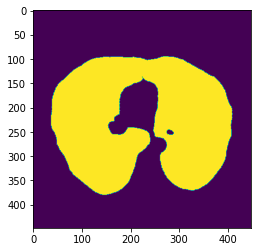

In [ ]:
import matplotlib.pyplot as plt
img, mask = next(iter(test_loader))
plt.imshow(mask[0,0])

**Predicted Mask**

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


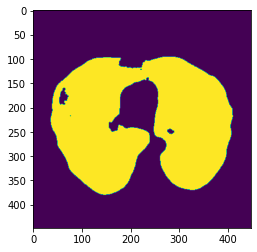

In [ ]:
img = img.to(device)
pred = model.forward(img)
pred = torch.round(pred)
pred = pred.detach().cpu().numpy()
plt.imshow(pred[0,0])